In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from itertools import product
import tensorflow as tf
from tensorflow import keras

# Process Data and Train Model

In [33]:
data = pd.read_csv("CAN_dataset.csv")
data = data[data.SubClass != 'Replay']
data.replace(to_replace=['Fuzzy'], value=['Fuzzing'], inplace = True) 

data["Data"] = data["Data"].fillna(0) 

dftemp = data.copy()
dftemp.replace(to_replace=['Normal', 'DOS', 'Fuzzing', 'Impersonation'],
value=[0,1,1,1], inplace= True)
y = dftemp['SubClass'].values

data.drop(["Class", "SubClass"], axis=1, inplace = True)

hex_to_dec = lambda x: int(x, 16)
remove_space = lambda x:  x.replace(" ","") 

data["Arbitration_ID"]= data["Arbitration_ID"].astype(str)
data["Arbitration_ID"] =data["Arbitration_ID"].apply(hex_to_dec)

data["Data"] = data["Data"].astype(str)
data["Data"]= data["Data"].apply(remove_space)
data["Data"]= data["Data"].apply(hex_to_dec)

X = data.values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)



In [34]:
learning_rates = [0.001, 0.01, 0.1]
optimizers = ['adam', 'sgd']
depths = [2, 3, 4]

param_grid = list(product(learning_rates, optimizers, depths))
print(param_grid)

[(0.001, 'adam', 2), (0.001, 'adam', 3), (0.001, 'adam', 4), (0.001, 'sgd', 2), (0.001, 'sgd', 3), (0.001, 'sgd', 4), (0.01, 'adam', 2), (0.01, 'adam', 3), (0.01, 'adam', 4), (0.01, 'sgd', 2), (0.01, 'sgd', 3), (0.01, 'sgd', 4), (0.1, 'adam', 2), (0.1, 'adam', 3), (0.1, 'adam', 4), (0.1, 'sgd', 2), (0.1, 'sgd', 3), (0.1, 'sgd', 4)]


In [35]:
def train_mlp(x_train, y_train, x_test, y_test, learning_rate=0.001, optimizer='adam', depth=2, epochs=3):
    # Define the model architecture
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(x_train.shape[1],)))
    
    for _ in range(depth):
        model.add(keras.layers.Dense(units=128, activation='relu'))
    
    model.add(keras.layers.Dense(units=10, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model
    model.fit(x_train, y_train, epochs=epochs, verbose=0)
    
    # Evaluate the model
    _, accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    return accuracy


Best Accuracy: 0.9966602921485901
Best Parameters: (0.001, 'adam', 4)


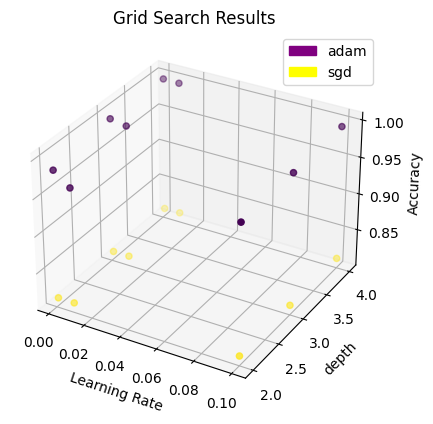

In [37]:
best_accuracy = 0.0
best_params = None
results = []
lr_values = []
optimizer_values = []
depth_values = []
for lr, optimizer, depth in param_grid:
    accuracy = train_mlp(X_train, y_train, X_test, y_test, learning_rate=lr, optimizer=optimizer, depth=depth)
    results.append(accuracy)
    lr_values.append(lr)
    optimizer_values.append(optimizer)
    depth_values.append(depth)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = (lr, optimizer, depth)

print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)

from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
optimizer_encoder = LabelEncoder()
optimizer_encoded = optimizer_encoder.fit_transform(optimizer_values)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(lr_values, depth_values, results, c=optimizer_encoded, cmap='viridis')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('depth')
ax.set_zlabel('Accuracy')
ax.set_title('Grid Search Results')

colors = {'adam':'purple', 'sgd':'yellow'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

    
plt.show()

In [38]:
def train_mlp_after_tune(x_train, y_train, x_test, y_test, learning_rate=0.001, optimizer='adam', depth=4, epochs=3):
    # Define the model architecture
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(x_train.shape[1],)))
    
    for _ in range(depth):
        model.add(keras.layers.Dense(units=128, activation='relu'))
    
    model.add(keras.layers.Dense(units=10, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model
    model.fit(x_train, y_train, epochs=epochs, verbose=0)

    # Evaluate the model
    y_pred = model.predict(x_test)
    y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

    accuracy = model.evaluate(x_test, y_test, verbose=0)[1]
    classification_report_output = classification_report(y_test, y_pred_classes)
    confusion_matrix_output = confusion_matrix(y_test, y_pred_classes)

    return accuracy, classification_report_output, confusion_matrix_output


In [39]:
accuracy, classification, cm =train_mlp_after_tune(X_train, y_train, X_val, y_val, learning_rate = 0.01, depth=4)
print(accuracy)
print(classification)
print(cm)

702/702 [==============================] - 1s 932us/step
0.9958587288856506
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18182
           1       1.00      0.98      0.99      4275

    accuracy                           1.00     22457
   macro avg       1.00      0.99      0.99     22457
weighted avg       1.00      1.00      1.00     22457

[[18179     3]
 [   90  4185]]
